This notebook aims to instill the flexibility of MCGLM alongside its comprehensive list of viable analyses.

In [70]:
import sys, os

sys.path.append(os.path.join(sys.path[0], ".."))

import statsmodels.api as sm
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from mcglm import MCGLM, mc_mixed, mc_id, mc_ma
from patsy import dmatrix
from statsmodels.tools.tools import add_constant
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.tsa.stattools import adfuller

import warnings

warnings.simplefilter("ignore")

MCGLM, a one-stop for statistical analysis.   

The statistical framework Multivariate Covariance Generalized Linear Models(MCGLM) provides a unified model for fitting in a wide variety of data such as gaussian or non-gaussian, univariate or multivariate, dependent or independent. This pliability comes from the second-moment assumptions and the straightforward yet thorough specification of pivotal model components. The specification of five components tuns the MCGLM framework: linear predictor/design matrix, link function, variance function, covariance function, and dependencies matrices Z. 

The Python library mcglm provides an easy interface for fitting the MCGLM model, similar to the library statsmodels, providing auxiliary methods to lead a proper specification of each MCGLM component. The library provides a comprehensive report for the model fitting analysis with regression parameters, dispersion parameters, confidence intervals, hypothesis testing, and Pearson residue. As yet, only users of R users have access to the MCGLM algorithm by the package mcglm. 

Finally, this notebook presents some statistical analysis with the support of Python mcglm.

Refs: 

https://www.jstor.org/stable/44681850    
https://www.researchgate.net/publication/324579147_Multiple_Response_Variables_Regression_Models_in_R_The_mcglm_Package    

In [2]:
print(MCGLM.__doc__)


        MCGLM class that implements MCGLM algorithm. (Bonat, Jørgensen 2015)
        
        It extends GLM for multi-responses and dependent components by fitting second-moment adjustment.

        Args:
            endog : array_like
                1d array of endogenous response variable. In case of multiple responses, the user must pass the responses on a list.  
            exog : array_like
                A dataset with the endogenous matrix in a Numpy fashion. Since the library doesn't set an intercept by default, the user must add it. In the case of multiple responses, the user must pass the design matrices as a python list. 
            z : array_like
                List with matrices components of the linear covariance matrix.
            link : array_like, string or None
                Specification for the link function. The MCGLM library implements the following options: identity, logit, power, log, probit, cauchy, cloglog, loglog, negativebinomial. In the case of No

The MCGLM framework behaves conditioned by the link and variance function. As this doc aims to demonstrate some of them. Let's get started with the first one: the ordinary least squares linear regression.

#### Linear Regression   

-------------

Perhaps the most popular statistical model, Linear Regression is a great choice when data meets the three assumptions:   

1. Linearity.   
2. Independence of components Y. a.k.a iid.   
3. The distribution of error following a Gaussian with tuple (0, dispersion).    



A statistical analysis on the classical Boston dataset.

In [23]:
from sklearn.datasets import load_boston

X, y = load_boston(return_X_y=True)
X = pd.DataFrame(X)
y = pd.Series(y, name="output")

Text(0.5, 1.0, 'Histogram of Boston Dataset')

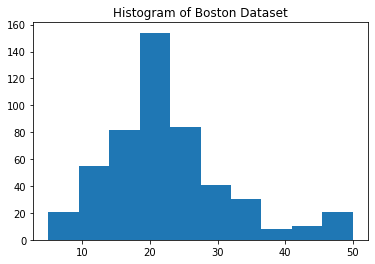

In [27]:
_ = plt.hist(y)
plt.title("Histogram of Boston Dataset")

MCGLM can adjust a similar ordinary linear regression as long as link and variance functions are settled with `identity` and `constant`, on top of independent components of $Y$.   

In [28]:
modelresults = MCGLM(endog=y, exog=X, z=[mc_id(X)]).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                      9
Model:                          MCGLM   No. Observations:                  506
link:                        identity   Df Residuals:                      492
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 08 Sep 2022   pAIC                           2569.58
Time:                        18:44:08   pBIC                           2628.75
                                        pLogLik                     -1270.7905
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0929      0.034     -2.734      0.006      -0.159      -0.026
1              0.0487      0.014      3.426      0.001       0.021       0.077
2             -0.0041      0.064     -0.064      0.949      -0.129       0.121
3              2.8540      0.892      3.199      0.001       1.105       4.603
4             -2.8684      3.315     -0.865      0.387      -9.366       3.630
5              5.9281      0.305     19.429      0.000       5.330       6.526
6             -0.0073      0.014     -0.533      0.594      -0.034       0.019
7             -0.9685      0.193     -5.015      0.000      -1.347      -0.590
8              0.1712      0.066      2.597      0.009       0.042       0.300
9             -0.0094      0.004     -2.426      0.015      -0.017      -0.002
10            -0.3922      0.108     -3.616      0.000      -0.605      -0.180
11             0.0149      0.003      5.600      0.000       0.010       0.020
12            -0.4163      0.050     -8.304      0.000      -0.515      -0.318
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    24.1670      3.308      7.305      0.000      17.683      30.651
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The residual analysis is key for assessing the fulfillment of the assumptions.

Text(0, 0.5, 'pearson residuals')

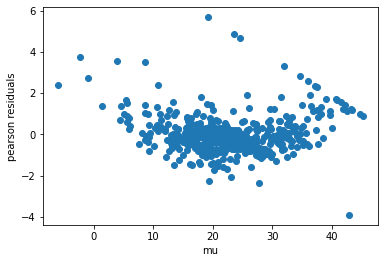

In [7]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

MCGLM allows us to try new link and variance functions quickly, and therefore the gaussianity. With a tweedie variance, the model can fit most GLM cases; with the power_fixed negative, the optimal p value.

In [44]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="tweedie",
    power=2,
    power_fixed=False,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                     49
Model:                          MCGLM   No. Observations:                  506
link:                             log   Df Residuals:                      492
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Thu, 08 Sep 2022   pAIC                           4288.16
Time:                        19:05:22   pBIC                           4347.33
                                        pLogLik                     -2130.0805
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0078      0.009     -0.893      0.372      -0.025       0.009
1              0.0020      0.004      0.539      0.590      -0.005       0.009
2             -0.0013      0.016     -0.080      0.936      -0.033       0.031
3              0.1339      0.228      0.587      0.558      -0.314       0.581
4              0.9172      0.848      1.081      0.280      -0.746       2.580
5              0.3103      0.078      3.973      0.000       0.157       0.463
6             -0.0001      0.003     -0.041      0.968      -0.007       0.007
7              0.0036      0.049      0.072      0.942      -0.093       0.100
8              0.0007      0.017      0.044      0.965      -0.032       0.034
9             -0.0003      0.001     -0.256      0.798      -0.002       0.002
10             0.0305      0.028      1.100      0.271      -0.024       0.085
11             0.0010      0.001      1.540      0.124      -0.000       0.002
12            -0.0183      0.013     -1.426      0.154      -0.043       0.007
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    -0.4720      0.393     -1.203      0.229      -1.241       0.297
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.5733      0.083     18.873      0.000       1.410       1.737
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

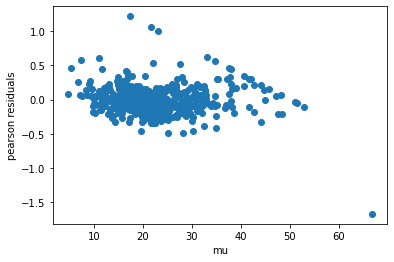

In [45]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

OLS has achieved a lower pAIC, which implies on a better fitting. Gaussianity for the win.   

It is also easy to adjust a geometric tweedie for variance.

In [50]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="geom_tweedie",
    power=2,
    power_fixed=False,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                 output   No. Iterations:                     49
Model:                          MCGLM   No. Observations:                  506
link:                             log   Df Residuals:                      492
variance:                geom_tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                     False
Date:                Thu, 08 Sep 2022   pAIC                           4535.92
Time:                        19:11:45   pBIC                            4595.1
                                        pLogLik                      -2253.962
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
0             -0.0078      0.011     -0.699      0.484      -0.030       0.014
1              0.0020      0.005      0.422      0.673      -0.007       0.011
2             -0.0013      0.021     -0.063      0.950      -0.042       0.039
3              0.1339      0.292      0.459      0.646      -0.438       0.706
4              0.9172      1.084      0.846      0.397      -1.207       3.042
5              0.3103      0.100      3.111      0.002       0.115       0.506
6             -0.0001      0.004     -0.032      0.975      -0.009       0.009
7              0.0036      0.063      0.057      0.955      -0.120       0.127
8              0.0007      0.022      0.035      0.972      -0.041       0.043
9             -0.0003      0.001     -0.201      0.841      -0.003       0.002
10             0.0305      0.035      0.861      0.389      -0.039       0.100
11             0.0010      0.001      1.205      0.228      -0.001       0.003
12            -0.0183      0.016     -1.117      0.264      -0.050       0.014
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    -2.9720      0.873     -3.405      0.001      -4.683      -1.261
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.5733      0.180      8.730      0.000       1.220       1.927
==============================================================================
"""

The variance function geom_tweedie hasn't improved the model.

##### A Count Model  

-------------
This dataset has information from a Canadian study of mortality by age and smoking status.  https://data.princeton.edu/wws509/datasets/#smoking. The four-column dataset establishes features: `age`, `smoking status`, `population`, and the outcome `deaths`.  

In [40]:
smoking_data = pd.read_csv("data/smoking_data.csv")

## exog and endog
X = dmatrix("~ pop + age + smoke", smoking_data, return_type="dataframe")
y = smoking_data["dead"]

Text(0.5, 1.0, 'Histogram of absolute count of deads')

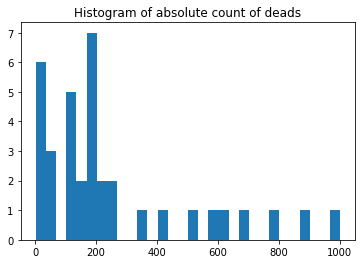

In [41]:
_ = plt.hist(y, bins=30)
plt.title("Histogram of absolute count of deads")

That is a long-tail distribution.

In [42]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                     22
Model:                          MCGLM   No. Observations:                   36
link:                        identity   Df Residuals:                       22
variance:                    constant   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 24 Oct 2022   pAIC                            429.44
Time:                        08:18:49   pBIC                            451.61
                                        pLogLik                       -200.719
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                  -224.6373     66.931     -3.356      0.001    -355.820     -93.455
age[T.45-59]                 95.3834     76.446      1.248      0.212     -54.448     245.215
age[T.50-54]                147.8634     78.491      1.884      0.060      -5.977     301.703
age[T.55-59]                216.4651     74.395      2.910      0.004      70.654     362.276
age[T.60-64]                344.0038     76.451      4.500      0.000     194.162     493.846
age[T.65-69]                426.7793     74.466      5.731      0.000     280.829     572.730
age[T.70-74]                399.1722     78.027      5.116      0.000     246.242     552.103
age[T.75-79]                335.9303     83.318      4.032      0.000     172.629     499.231
age[T.80+]                  293.7420     86.312      3.403      0.001     124.573     462.911
smoke[T.2.cigarPipeOnly]     32.3389     49.616      0.652      0.515     -64.906     129.584
smoke[T.3.cigarrettePlus]    85.2001     76.811      1.109      0.267     -65.347     235.747
smoke[T.4.cigarretteOnly]    87.8965     60.879      1.444      0.149     -31.425     207.218
pop                           0.1128      0.023      4.814      0.000       0.067       0.159
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1  1.107e+04   1899.729      5.825      0.000    7342.640    1.48e+04
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Let's try a "tweedie adjustment" with power set as one, the Poisson one.

In [44]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="log",
    variance="tweedie",
    power=1,
    power_fixed=True,
).fit()

modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                   dead   No. Iterations:                     12
Model:                          MCGLM   No. Observations:                   36
link:                             log   Df Residuals:                       22
variance:                     tweedie   Df Model:                           14
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 24 Oct 2022   pAIC                            371.22
Time:                        08:19:13   pBIC                            393.39
                                        pLogLik                      -171.6112
=============================================================================================
                                coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------------------
Intercept                     2.5604      0.283      9.055      0.000       2.006       3.115
age[T.45-59]                  0.6242      0.310      2.011      0.044       0.016       1.233
age[T.50-54]                  1.0038      0.308      3.261      0.001       0.401       1.607
age[T.55-59]                  1.3818      0.245      5.635      0.000       0.901       1.862
age[T.60-64]                  1.5012      0.245      6.132      0.000       1.021       1.981
age[T.65-69]                  2.1366      0.240      8.919      0.000       1.667       2.606
age[T.70-74]                  2.3557      0.269      8.765      0.000       1.829       2.882
age[T.75-79]                  2.2041      0.298      7.402      0.000       1.621       2.788
age[T.80+]                    1.9506      0.318      6.143      0.000       1.328       2.573
smoke[T.2.cigarPipeOnly]      0.2114      0.176      1.203      0.229      -0.133       0.556
smoke[T.3.cigarrettePlus]     0.5030      0.214      2.347      0.019       0.083       0.923
smoke[T.4.cigarretteOnly]     0.7818      0.164      4.755      0.000       0.460       1.104
pop                           0.0004   6.25e-05      6.679      0.000       0.000       0.001
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1    14.1210      3.786      3.730      0.000       6.701      21.541
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

Text(0, 0.5, 'pearson residuals')

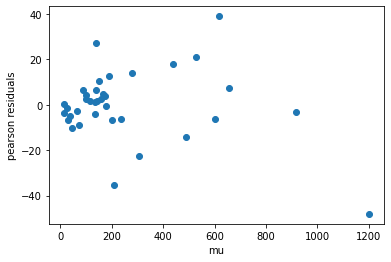

In [45]:
# Residual Analysis
plt.scatter(modelresults.mu, modelresults.pearson_residuals)
plt.xlabel("mu")
plt.ylabel("pearson residuals")

The usual Tweedie variance function is a suitable pick.

##### Bounded data
-------------

The titanic dataset.

In [46]:
titanic = pd.read_csv("data/titanic.csv")

In [47]:
y = titanic["Survived"]

X = titanic[["Fare", "SibSp", "Embarked", "Parch", "Pclass"]]
X = X.fillna("S")

X = dmatrix("~ Fare + SibSp + Embarked + Parch + Pclass", X, return_type="dataframe")

In [49]:
modelresults = MCGLM(
    y,
    X,
    [mc_id(X)],
    link="logit",
    variance="binomialP",
    ntrial=1,
).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Survived   No. Iterations:                      0
Model:                          MCGLM   No. Observations:                  891
link:                           logit   Df Residuals:                      883
variance:                   binomialP   Df Model:                            8
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 24 Oct 2022   pAIC                             213.8
Time:                        19:28:36   pBIC                            252.14
                                        pLogLik                       -98.9013
=================================================================================
                    coef    std err          z      P>|z|      [0.025      0.975]
---------------------------------------------------------------------------------
Intercept         1.4120      0.343      4.119      0.000       0.740       2.084
Embarked[T.Q]     0.2911      0.307      0.948      0.343      -0.311       0.893
Embarked[T.S]    -0.5179      0.197     -2.635      0.008      -0.903      -0.133
Fare              0.0037      0.002      1.553      0.120      -0.001       0.008
SibSp            -0.1274      0.082     -1.560      0.119      -0.288       0.033
Parch             0.2920      0.101      2.904      0.004       0.095       0.489
Pclass           -0.7556      0.116     -6.503      0.000      -0.983      -0.528
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     0.9990      0.036     27.996      0.000       0.929       1.069
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

For a bounded scenario, we have four different link functions on the mcglm library.

In [50]:
## Evaluating multiple links
modelresults_logit = MCGLM(
    y, X, [mc_id(X)], link="logit", variance="binomialP", ntrial=1
).fit()

modelresults_loglog = MCGLM(
    y, X, [mc_id(X)], link="loglog", variance="binomialP", ntrial=1
).fit()

modelresults_cloglog = MCGLM(
    y, X, [mc_id(X)], link="cloglog", variance="binomialP", ntrial=1
).fit()

modelresults_cauchy = MCGLM(
    y, X, [mc_id(X)], link="cauchy", variance="binomialP", ntrial=1
).fit()

In [51]:
print(
    "logit_aic: ",
    modelresults_logit.aic,
    ", loglog_aic: ",
    modelresults_loglog.aic,
    ", cloglog_aic: ",
    modelresults_cloglog.aic,
    ", cauchy_aic: ",
    modelresults_cauchy.aic,
)

logit_aic:  213.8 , loglog_aic:  200.75 , cloglog_aic:  223.56 , cauchy_aic:  218.02


The loglog link is the best pick for this analysis.

In addition to it, the mcglm can fit data when components are not independent.

------------------

### Dependence section

Moving Average model. 

The library `statmodels` has an amazing API to craft Arma process. Let's use it to generate data, and then adjust a model.

In [113]:
from statsmodels.tsa.arima_process import ArmaProcess

arma_obj = ArmaProcess(ar=[1], ma=[1, 2])
arma_sample = arma_obj.generate_sample(nsample=300)

data = pd.DataFrame()
data["arma_sample"] = arma_sample
data["index"] = list(range(0, 300))
data = add_constant(data)

X = data[["const"]]
y = data["arma_sample"]

<AxesSubplot:xlabel='index', ylabel='arma_sample'>

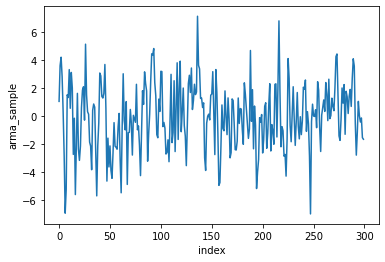

In [114]:
sns.lineplot(data["index"], data["arma_sample"])

By default, time-series analysis starts with the usual decomposition on trend, seasonal and residual(shock). In this analysis, as long as we have crafted from ARMA process, we can adjust a model MA straight off the bat.

The measure of goodness-of-fit pAIC is crucial to point the best pick.

In [115]:
one_order = [mc_id(X), mc_ma(id="const", time="index", data=data, order=1)]
two_order = [*one_order, mc_ma(id="const", time="index", data=data, order=2)]
three_order = [*two_order, mc_ma(id="const", time="index", data=data, order=3)]
four_order = [*three_order, mc_ma(id="const", time="index", data=data, order=4)]
five_order = [*four_order, mc_ma(id="const", time="index", data=data, order=5)]
six_order = [*five_order, mc_ma(id="const", time="index", data=data, order=6)]
seven_order = [*six_order, mc_ma(id="const", time="index", data=data, order=7)]

In [116]:
for index, order in enumerate(
    [one_order, two_order, three_order, four_order, five_order, six_order, seven_order]
):
    modelresults = MCGLM(y, X, order).fit()

    print("q value: ", str(index + 1), ", paic: ", modelresults.aic)

q value:  1 , paic:  998.91
q value:  2 , paic:  999.91
q value:  3 , paic:  1000.99
q value:  4 , paic:  1002.83
q value:  5 , paic:  1004.2
q value:  6 , paic:  1005.36
q value:  7 , paic:  1006.65


Lag size q as 1 as the best fit.

In [117]:
modelresults = MCGLM(y, X, one_order).fit()
modelresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:            arma_sample   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                  300
link:                        identity   Df Residuals:                      297
variance:                    constant   Df Model:                            3
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Mon, 24 Oct 2022   pAIC                            998.91
Time:                        20:46:32   pBIC                           1010.02
                                        pLogLik                      -496.4536
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0119      0.178     -0.067      0.947      -0.361       0.337
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.3560      0.514     10.411      0.000       4.348       6.364
dispersion_2     2.0900      0.278      7.508      0.000       1.544       2.636
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

The summary report drills down the $\theta$ parameters that linearly operates the white noise.

##### Random Effect models.
-------------

MCGLM can also approach the notorious random effect models, with random slope and intercept.

In [37]:
# Top 10 cells to get an intuition about data.
sleepstudy = pd.read_csv(
    "data/first_simulation/sleepstudy.csv", dtype={"Subject": "str"}
)

sleepstudy.head(10)

,Reaction,Days,Subject
0,249.5600,0,308
1,258.7047,1,308
2,250.8006,2,308
3,321.4398,3,308
4,356.8519,4,308
5,414.6901,5,308
6,382.2038,6,308
7,290.1486,7,308
8,430.5853,8,308
9,466.3535,9,308


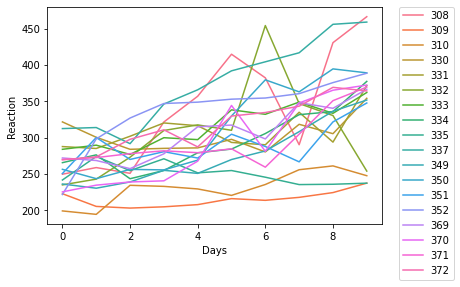

In [38]:
## Plotting curve of 18 subjects
_ = sns.lineplot(x="Days", y="Reaction", hue="Subject", data=sleepstudy)
plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.0)

In [39]:
# Design Matrix
X = dmatrix("~ Days", sleepstudy, return_type="dataframe")

# Z specification
Z = [mc_id(sleepstudy)] + mc_mixed(formula="~ 0 + Subject / Days", data=sleepstudy)

In [40]:
# Model fitting
mcglm = MCGLM(endog=sleepstudy["Reaction"], exog=X, z=Z)

mcglmresults = mcglm.fit()

In [41]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:               Reaction   No. Iterations:                     20
Model:                          MCGLM   No. Observations:                  180
link:                        identity   Df Residuals:                      174
variance:                    constant   Df Model:                            6
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 08 Sep 2022   pAIC                           1583.94
Time:                        20:54:09   pBIC                            1603.1
                                        pLogLik                      -785.9704
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept    251.4051      6.632     37.906      0.000     238.406     264.404
Days          10.4673      1.502      6.968      0.000       7.523      13.412
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1   654.9420     70.624      9.274      0.000     516.521     793.363
dispersion_2   565.5150    264.679      2.137      0.033      46.753    1084.277
dispersion_3    32.6820     13.560      2.410      0.016       6.105      59.259
dispersion_4    11.0550     42.948      0.257      0.797     -73.121      95.231
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
==============================================================================
"""

#### Beta coefficients  
The Beta section diagnose the fixed-effects parameters, that is to say, the conclusion overall subjects.  

    Intercept set at value 251.40. The straightforward takeaway is: At day 0, the average response time is roughly 251 seconds.
    In addition, Days at 10.46 allude to total change to response time by unit changes on Days, for subjects with random effects set to 0.
    Furthermore, by the results of the wald test on Days, we might conclude that days are statistically significant in the statistical model.
---
#### Dispersion parameters   
The Dispersion parameters allude to random effects within individuals throughout the days.  

    The first dispersion parameter is the variance across all data points. Calculated in 654.94.
    The second dispersion parameter is the variance across all intercepts, which is 565.51.
    The third dispersion parameter is the variance across all slopes. Calculated in 32.68. 
    The fourth dispersion parameter is the variance across intercepts and slopes. Calculated in 11.05.

* Moreover, the correlation might be calculated through the formula = dispersion_4/(sqrt(dispersion_2) + sqrt(dispersion_3)). Cell below shows the pearson correlation result, 0.37.   

##### Multivariate Models
-------------

Soya

`Soya` is a dataset that stores an experiment of Universidade Federal da Grande Dourados in Dourados, Mato Grosso do Sul, Brazil. Description:    
https://github.com/walmes/wzRfun/blob/master/R/wzRfun.R#L10   
http://ccarevista.ufc.br/seer/index.php/ccarevista/article/view/1454  

The experiment collected data about different treatments of `potassium`, `water`, and `blocks` for soil farming on buckets. All of those covariates are categorical. The response traits to be analyzed are: `grain size`, `total seeds`, and `viable peas`, which stands for the weight of hundred grains, total grain per bucket, and percentage of viable peas(green beans). In the following, MCGLM fits onto this data with three unique kinds of answers: continuous, count, and binomial.

In [42]:
soya = pd.read_csv(
    "data/fourth_simulation/soya.csv",
    dtype={"block": "str", "water": "str", "pot": "str"},
)

soya["viablegrain"] = soya["viablepeas"] / soya["totalpeas"]

In [43]:
# percentual of peas.
soya["viablePeas"] = soya["viablepeas"] / soya["totalpeas"]

# Design matrix.
X = dmatrix("~ block + water * pot", soya, return_type="dataframe")

In [44]:
# Model Specification
mcglm = MCGLM(
    endog=[soya["grain"], soya["seeds"], soya["viablePeas"]],
    exog=[X, X, X],
    z=[[mc_id(soya)], [mc_id(soya)], [mc_id(soya)]],
    link=["identity", "log", "logit"],
    variance=["constant", "tweedie", "binomialP"],
    ntrial=[None, None, soya["totalpeas"].values],
)


mcglmresults = mcglm.fit()

In [45]:
mcglmresults.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  grain   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                   75
link:                        identity   Df Residuals:                       55
variance:                    constant   Df Model:                           20
Method:              Quasi-Likelihood   Power-fixed:                      True
Date:                Thu, 08 Sep 2022   pAIC                            448.21
Time:                        20:56:33   pBIC                            516.53
                                        pLogLik                      -204.1064
============================================================================================
                               coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept                   14.2456      1.218     11.699      0.000      11.859      16.632
block[T.II]                  1.1324      0.880      1.286      0.198      -0.593       2.858
block[T.III]                -0.7801      0.880     -0.886      0.376      -2.506       0.946
block[T.IV]                 -1.5492      0.880     -1.760      0.078      -3.275       0.176
block[T.V]                  -2.3871      0.880     -2.711      0.007      -4.113      -0.661
water[T.50]                  2.1661      1.531      1.415      0.157      -0.835       5.167
water[T.62.5]                2.5404      1.531      1.659      0.097      -0.460       5.541
pot[T.120]                  11.7898      1.531      7.701      0.000       8.789      14.790
pot[T.180]                  11.8633      1.531      7.749      0.000       8.863      14.864
pot[T.30]                    6.7895      1.531      4.435      0.000       3.789       9.790
pot[T.60]                   10.3978      1.531      6.792      0.000       7.397      13.399
water[T.50]:pot[T.120]       2.2543      2.165      1.041      0.298      -1.989       6.498
water[T.62.5]:pot[T.120]     5.5828      2.165      2.578      0.010       1.339       9.826
water[T.50]:pot[T.180]       1.2096      2.165      0.559      0.576      -3.034       5.453
water[T.62.5]:pot[T.180]     9.2389      2.165      4.267      0.000       4.995      13.483
water[T.50]:pot[T.30]        0.1067      2.165      0.049      0.961      -4.137       4.350
water[T.62.5]:pot[T.30]     -1.8678      2.165     -0.863      0.388      -6.112       2.376
water[T.50]:pot[T.60]        2.6034      2.165      1.202      0.229      -1.640       6.847
water[T.62.5]:pot[T.60]      3.3586      2.165      1.551      0.121      -0.885       7.602
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
dispersion_1     5.8620      1.671      3.508      0.000       2.587       9.137
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
power_         1.0000        nan        nan        nan         nan         nan
               Multivariate Covariance Generalized Linear Model               
==============================================================================
Dep. Variable:                  seeds   No. Iterations:                     10
Model:                          MCGLM   No. Observations:                   75
link:                             log   Df Residuals:                       55
variance:                     tweedie   Df Model:                           20
Me

The three responses have generated a three-section report. As it follows, a analysis per response.

---
`grain` size.

The grain response was fitted with default parameters, `identity` and `constant`, generating a near homoscedastic linear model. Among covariates `block`, `water` and `potassium`, by Wald test, potassium levels are statistically significant for the model; the higher potassium level, bigger grain size. Variance constant on 5.862.   

Residual analysis:

Text(0, 0.5, 'pearson residual')

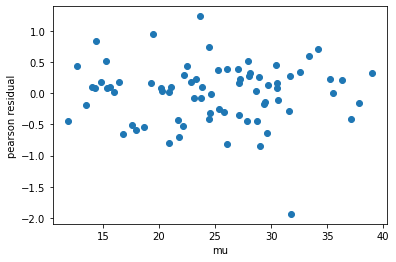

In [46]:
# grain. residual analysis
plt.scatter(mcglmresults.mu[0], mcglmresults.pearson_residuals[0])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Despite the outlier, the fit seems pretty good.

---
`seed` count.

As long as seed is a count variable, a straightforward and canonical way to model it is Poisson. Two out of three covariates are statistically significant on `seed`: potassium, for every level; and black for level V.

Residual analysis:

Text(0, 0.5, 'pearson residual')

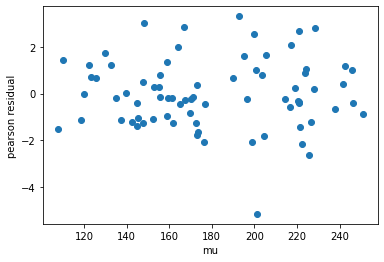

In [47]:
# seeds. residual analysis
plt.scatter(mcglmresults.mu[1], mcglmresults.pearson_residuals[1])
plt.xlabel("mu")
plt.ylabel("pearson residual")

Notwithstanding the outlier, the fit seems pretty good.

---
Percentage of `viable peas`.

Binomial N trials is the adequate model for bounded data. Perhaps, the most popular solution to fit is the `Logit` link, the one used. Among covariates, only potassium level 30, and water level 50 are statistically significant with Viable Peas.

Residual Analysis:

Text(0, 0.5, 'pearson residual')

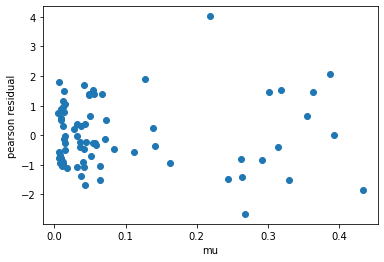

In [48]:
# viablepeasP. residual analysis
plt.scatter(mcglmresults.mu[2], mcglmresults.pearson_residuals[2])
plt.xlabel("mu")
plt.ylabel("pearson residual")

The model has not fitted well. It is possible to try out different values for link and variance functions. Suppose it does not improve the model fit. In that case, it will let us conclude a non-assessment for the percentage of viable peas from current covariates.   

The last three components rhos allude to the correlation coefficient among responses. 
 * rho_1 stands for grain size and whole seeds, with a considerable Pearson correlation of 0.63.
 * rho_2 and rho_3 stand for correlation between grain size and viable peas, seed count, and viable peas, respectively. Both correlations are low. 